In [1]:
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot #MINE

import csv
import sys

In [2]:
steps = 2000 # int(sys.argv[1])  # number of training steps
iteration = 5 # int(sys.argv[2])  # number of iterations (iid runs)
d = 1 # int(sys.argv[3])  # dimension of the distributions
mb_size = 4000 # int(sys.argv[4])  # batch size
N = 40000 # [5000, 10000, 20000, 50000, 100000, 150000] # t = 0.1 # sys.argv[5]
W = [0, 0.003125, 0.00625, 0.0125, 0.025, 0.05, 0.1] # 0.2 # subpopulation ratio
print(steps)
print(iteration)
print(d)
print(mb_size)
print(N)


2000
5
1
4000
40000


In [3]:
# hyperparameters
if d==2:
    layers = [d, 16, 16, 8, 1]
elif d==10:
    layers = [d, 32, 32, 16, 1]
elif d==50:
    layers = [d, 64, 64, 32, 1]
elif d==1:                      #MINE
    layers = [d, 16, 16, 8, 1]# [d, 8, 8, 4, 1] #[d, 4, 4, 2, 1] #

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [4]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  #h = [x, x**2] and fix D_w dimension
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    #out = 10.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 10.0)
    #out = 50.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 50.0)
    out = 1.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 1.0)

    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [9]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(W), iteration)) # np.zeros(shape=(No_alpha, iteration))  <----------
RD_exact_w =  np.zeros(shape= len(W))


In [10]:

# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, w in enumerate(W): # range(No_alpha):  # <-------------------
    
    print('j=', j)
    print('n=', w)
    
    # load data
    #fname = 'data/mu2_1_arch_16/N'+str(n)+'_a_0.5_and_3.7/input_data/GMM_d_1_'
    fname = 'data/GMM_d_'+str(d)+'_'
    data = scipy.io.loadmat(fname + 'data_'+str(w)+'.mat')
    x_ = np.array(data['x'])
    y_ = np.array(data['y'])

    params = scipy.io.loadmat(fname + 'params_'+str(w)+'.mat')
    alpha = np.array(params['alpha'])
    RD_exact = np.array(params['RD_exact']) # contains exact for all alphas
    No_alpha = alpha.shape[0]
    
    
    # alpha range for these data files is [-10: 0.5:12]
    a_Ren_pos = 13 # enumeration from 0... #14 -> a=0.5 (position of the vector with alpha's)
    beta = lam*(1-alpha[a_Ren_pos])  #   <----------- choose the first alpha value
    gamma = lam*alpha[a_Ren_pos]  #  <---------- choose the first alpha value
    
    #exact value for Renyi (estimated by integral computation)
    RD_exact_w[j] = RD_exact[a_Ren_pos];
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake
    total_loss = D_loss

    #D_solver = tf.train.AdamOptimizer().minimize(total_loss, var_list=theta_D)
    D_solver = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())

        x = x_[np.random.randint(x_.shape[0], size=int(0.8*x_.shape[0])), :]
        y = y_[np.random.randint(y_.shape[0], size=int(0.8*x_.shape[0])), :]

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

 
    # -----------------------------------------------------------------------------
    # Plotting
    # -----------------------------------------------------------------------------
    if not os.path.exists('data/out_GMM_BS_plots_over_W/'):
        os.makedirs('data/out_GMM_BS_plots_over_W/')

    fig = plt.figure()
    #plt.plot(D_loss_plot)
    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
    plt.plot(x_idx, D_loss_plot)
    plt.xlabel('steps')
    plt.ylabel('D loss')
    plt.savefig('data/out_GMM_BS_plots_over_W/cgan_Dloss' + str(j) + 'w_' + str(w) +'.png', bbox_inches='tight')
    plt.close(fig)
   


j= 0
n= 0
Iteration: 0
Iter: 0
Renyi divergence: [-4.96555e-07]

Iter: 1000
Renyi divergence: [0.00026687]

Iteration: 1
Iter: 0
Renyi divergence: [4.464644e-06]

Iter: 1000
Renyi divergence: [0.00017848]

Iteration: 2
Iter: 0
Renyi divergence: [-5.5580167e-06]

Iter: 1000
Renyi divergence: [-0.00014099]

Iteration: 3
Iter: 0
Renyi divergence: [7.3743286e-06]

Iter: 1000
Renyi divergence: [-0.00032693]

Iteration: 4
Iter: 0
Renyi divergence: [5.8326987e-06]

Iter: 1000
Renyi divergence: [0.00029127]

j= 1
n= 0.003125
Iteration: 0
Iter: 0
Renyi divergence: [-8.75516e-07]

Iter: 1000
Renyi divergence: [-0.00025184]

Iteration: 1
Iter: 0
Renyi divergence: [-1.4455246e-05]

Iter: 1000
Renyi divergence: [-0.00063217]

Iteration: 2
Iter: 0
Renyi divergence: [5.896236e-06]

Iter: 1000
Renyi divergence: [2.6978552e-05]

Iteration: 3
Iter: 0
Renyi divergence: [-6.0275197e-06]

Iter: 1000
Renyi divergence: [1.4916062e-05]

Iteration: 4
Iter: 0
Renyi divergence: [-4.03999e-06]

Iter: 1000
Renyi d

In [11]:
   

with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(w)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)


In [12]:
data_back = D_loss_vals


Text(0, 0.5, 'divergence')

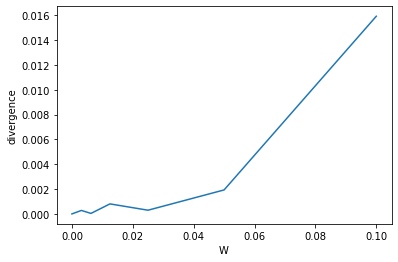

In [13]:
# Plot RD vs N
#======================
fig = plt.figure()
#x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
plt.plot(W, D_loss_vals[:,0])
plt.xlabel('W')
plt.ylabel('divergence')

(-0.007, 0.02)

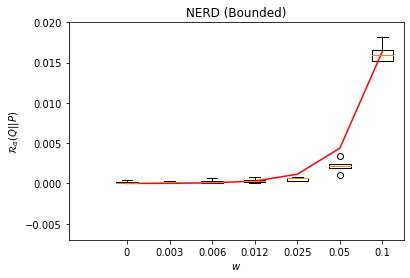

In [18]:


fig1, ax1 = plt.subplots()
ax1.set_title('NERD (Bounded)')
ax1.boxplot(np.transpose(D_loss_vals[:,:]) , labels=[0, 0.003, 0.006, 0.012, 0.025, 0.05, 0.1], whis=2)
ax1.plot(np.arange(1,8), RD_exact_w[:],'r', 'LineWidth', 2 );
plt.xlabel(r'$w $')
plt.ylabel(r'$\mathcal{R}_{\alpha}(Q||P)$')
plt.ylim(-0.007, 0.02)


In [ ]:
print('program terminated succesfully')